In [1]:
# Uncomment to install deps through here
#!pip install fastai python-dotenv google-cloud-bigquery

In [105]:
from fastai.tabular.all import *
from fastinference.tabular import *
from datetime import datetime,timedelta
from dotenv import load_dotenv
from google.cloud import bigquery
import matplotlib.style
import matplotlib as mpl
import os
sys.path.append('../')
from lib.github import fetch

In [106]:
# Set some defaults
mpl.rcParams['font.size'] = 14
pd.set_option('display.max_columns', None)

# Load secrets from environment variables to avoid showing them in shared notebook snapshots
load_dotenv(dotenv_path='/storage/.env')

# Define variables
flush = False
use_cat = False
use_fresh = False
var_viewer_login = 'chillu'
var_bigquery_table = 'silverstripe.com:api-project-617183295772.github_silverstripe_events.events_chillu'
var_date_min=(datetime.now() - timedelta(days=4*365))
var_date_max=(datetime.now() - timedelta(days=30))
var_results_path='/storage/results.csv'

In [107]:
# https://towardsdatascience.com/normalization-vs-standardization-cb8fe15082eb
def normalise(x):
    return (x-min(x))/(max(x)-min(x))

In [108]:
def preprocess(df):
    # Fill missing values with zeroes
    df = df.fillna(value=0)
    # Clip outliers in scoring inputs to provide a better range to the regression
    df['viewer_events_count'].clip(upper=3, inplace=True)
    df['viewer_comments_count'].clip(upper=3, inplace=True)
    df['viewer_comments_body_count'].clip(upper=1000, inplace=True)
    # Inconsistencies between githubarchive and Github API, cap to avoid noise
    df['viewer_repo_issues_opened_count'].clip(upper=5, inplace=True)
    df['viewer_repo_pull_requests_opened_count'].clip(upper=5, inplace=True)
    df['creator_repo_issues_opened_count'].clip(upper=5, inplace=True)
    df['creator_repo_pull_requests_opened_count'].clip(upper=5, inplace=True)
    return df

In [109]:
# Get subset of githubarchive.org data
# DANGER DANGER This query can cost up to $30USD
query1 = ("""
SELECT 
id, 
type, 
created_at, 
repo.name AS repo_name, 
repo.id AS repo_id, 
actor.login AS actor_login, 
actor.id AS actor_id, 
org.id AS org_id, 
org.login AS org_login, 
payload
FROM `githubarchive.day.2*`
WHERE
# Date without the leading "2" (workaround to filter out "yesterday" table naming)
_TABLE_SUFFIX BETWEEN '{var_date_min}' AND '{var_date_max}'
AND actor.login = '{var_viewer_login}'
""".format(
    var_viewer_login=var_viewer_login,
    var_date_min=var_date_max.strftime('%Y-%m-%d')[1:],
    var_date_max=var_date_max.strftime('%Y-%m-%d')[1:]
))
# TODO Create view from query1

In [110]:
query2 = ("""
# Get events with baseline analysis
SELECT
*,
(type IN ('IssueCommentEvent', 'PullRequestReviewCommentEvent', 'PullRequestCommentEvent')) AS is_comment,
(JSON_EXTRACT_SCALAR(payload, '$.action') = 'create' AND actor_login = '{var_viewer_login}') AS is_author,
(body IS NOT NULL AND body LIKE CONCAT('%@', '{var_viewer_login}', '%')) AS is_at_mentioned,
# TODO Includes @param, @return etc.
ARRAY_TO_STRING(REGEXP_EXTRACT_ALL(body, r'(?:^|\s)(@[a-zA-Z0-9-_//]+)'),',') AS at_mentions,
ARRAY_LENGTH(REGEXP_EXTRACT_ALL(body, r'(?:^|\s)(@[a-zA-Z0-9-_//]+)')) AS at_mentions_count,
CHAR_LENGTH(title) AS title_chars_count,
CHAR_LENGTH(body) AS body_chars_count,
ARRAY_LENGTH(REGEXP_EXTRACT_ALL(body, r'[#\*]')) AS markdown_chars_count
FROM (
  # Get all relevant events in relevant repos.
  # Normalise some data between types.
  SELECT
    *,
    JSON_EXTRACT_SCALAR(payload, '$.action') AS action,
    COALESCE(
      JSON_EXTRACT_SCALAR(payload, '$.issue.id'),
      JSON_EXTRACT_SCALAR(payload, '$.pull_request.id')
    ) AS item_id,
    COALESCE(
      JSON_EXTRACT_SCALAR(payload, '$.issue.url'),
      JSON_EXTRACT_SCALAR(payload, '$.pull_request.url')
    ) AS item_url,
    # TODO Keep empty for comments
    COALESCE(
      JSON_EXTRACT_SCALAR(payload, '$.issue.title'),
      JSON_EXTRACT_SCALAR(payload, '$.pull_request.title')
    ) AS title,
    COALESCE(
      JSON_EXTRACT_SCALAR(payload, '$.comment.body'),
      JSON_EXTRACT_SCALAR(payload, '$.issue.body'),
      JSON_EXTRACT_SCALAR(payload, '$.pull_request.body')
    ) AS body
  FROM `{var_bigquery_table}`
  WHERE
    repo_id IN (
      # Get all repos which the user has interacted with
      SELECT repo_id
      FROM `{var_bigquery_table}`
      WHERE
        actor_login = '{var_viewer_login}'
        AND created_at BETWEEN '{var_date_min}' AND '{var_date_max}'
      GROUP BY repo_id
    )
    AND created_at BETWEEN '{var_date_min}' AND '{var_date_max}'
    AND type IN ('IssuesEvent', 'PullRequestEvent', 'IssueCommentEvent', 'PullRequestReviewCommentEvent', 'PullRequestCommentEvent')
)
""".format(
    var_viewer_login=var_viewer_login,
    var_bigquery_table=var_bigquery_table,
    var_date_min=var_date_min.strftime('%Y-%m-%d'),
    var_date_max=var_date_max.strftime('%Y-%m-%d')
))
# TODO Create view from query2

In [111]:
query3 = ("""
WITH
all_events AS (
  SELECT *
  FROM `{var_bigquery_table}`
),
opened_events AS (
  SELECT *
  FROM `{var_bigquery_table}`
  WHERE type IN ('IssuesEvent', 'PullRequestEvent') AND action = 'opened' 
  ORDER BY created_at ASC
),
viewer_events AS (
  SELECT *
  FROM `{var_bigquery_table}`
  WHERE actor_login = '{var_viewer_login}'
  ORDER BY created_at ASC
),
repo_event_counts_by_actor AS (
  SELECT
  repo_id,
  actor_login,
  COUNT(*) AS event_count,
  COUNTIF(type = 'IssuesEvent' AND action = 'opened') AS issues_opened_count,
  COUNTIF(type = 'PullRequestEvent' AND action = 'opened') AS pull_requests_opened_count
  FROM `{var_bigquery_table}`
  WHERE created_at BETWEEN '{var_date_min}' AND '{var_date_max}'
  GROUP BY 1,2
)

SELECT DISTINCT
# Leading indicators (available on new items)
opened_events.item_id,
opened_events.item_url,
opened_events.org_id,
opened_events.repo_id,
opened_events.actor_login AS creator_login,
opened_events.type,
opened_events.created_at,
opened_events.is_at_mentioned AS viewer_is_at_mentioned,
opened_events.title_chars_count,
opened_events.body_chars_count,
opened_events.markdown_chars_count,
# Scoring indicators
repo_event_counts_by_viewer.issues_opened_count AS viewer_repo_issues_opened_count,
repo_event_counts_by_viewer.pull_requests_opened_count AS viewer_repo_pull_requests_opened_count,
repo_event_counts_by_creator.issues_opened_count AS creator_repo_issues_opened_count,
repo_event_counts_by_creator.pull_requests_opened_count AS creator_repo_pull_requests_opened_count,
COUNTIF(all_events.actor_login = '{var_viewer_login}') AS viewer_events_count,
COUNTIF(all_events.is_comment = true AND all_events.actor_login = '{var_viewer_login}') AS viewer_comments_count,
# Trailing indicators (not available on newly created items)
STRING_AGG(all_events.at_mentions) AS all_at_mentions,
STRING_AGG(all_events.actor_login) AS all_actors,
COUNT(all_events.id) AS events_count,
COUNTIF(all_events.is_comment = true) AS comments_count,
CHAR_LENGTH(STRING_AGG(all_events.body)) AS comments_body_count,
SUM(all_events.at_mentions_count) AS at_mentions_count,
COUNTIF(all_events.is_at_mentioned = true) AS viewer_at_mentions_count,
(SELECT CHAR_LENGTH(STRING_AGG(viewer_events.body)) FROM viewer_events WHERE opened_events.item_id = viewer_events.item_id) AS viewer_comments_body_count
# Due to the nature of event streams, the opened event might not be in the source data set (cutoff by date filter)
FROM opened_events
LEFT JOIN all_events
    ON all_events.item_id = opened_events.item_id
LEFT JOIN repo_event_counts_by_actor AS repo_event_counts_by_viewer
  ON repo_event_counts_by_viewer.actor_login = '{var_viewer_login}' AND opened_events.repo_id = repo_event_counts_by_viewer.repo_id
LEFT JOIN repo_event_counts_by_actor AS repo_event_counts_by_creator
  ON opened_events.actor_login = repo_event_counts_by_creator.actor_login AND opened_events.repo_id = repo_event_counts_by_creator.repo_id
WHERE opened_events.created_at BETWEEN '{var_date_min}' AND '{var_date_max}'
GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
ORDER BY opened_events.created_at ASC
""".format(
    var_viewer_login=var_viewer_login,
    var_bigquery_table=var_bigquery_table,
    var_date_min=var_date_min.strftime('%Y-%m-%d'),
    var_date_max=var_date_max.strftime('%Y-%m-%d')
))

In [112]:
# Fetch results if not already present
if flush == True or not os.path.isfile(var_results_path):
    client = bigquery.Client()
    df = client.query(query3).to_dataframe()
    df.to_csv(var_results_path)
else:
    df = pd.read_csv(var_results_path)
    
df['fresh'] = False
df = df.set_index(['item_url', 'fresh'])

In [113]:
# Preview raw data
df

,,Unnamed: 0,item_id,org_id,repo_id,creator_login,type,created_at,viewer_is_at_mentioned,title_chars_count,body_chars_count,markdown_chars_count,viewer_repo_issues_opened_count,viewer_repo_pull_requests_opened_count,creator_repo_issues_opened_count,creator_repo_pull_requests_opened_count,viewer_events_count,viewer_comments_count,all_at_mentions,all_actors,events_count,comments_count,comments_body_count,at_mentions_count,viewer_at_mentions_count,viewer_comments_body_count
item_url,fresh,,,,,,,,,,,,,,,,,,,,,,,,,
https://api.github.com/repos/dnadesign/silverstripe-elemental/pulls/49,False,0,85699593,2148312.0,23339883,SilbinaryWolf,PullRequestEvent,2016-09-18 06:47:42+00:00,False,106,227.0,0.0,14.0,7.0,2,7,0,0,",","wilr,SilbinaryWolf",2,0,455.0,0.0,0,NaN
https://api.github.com/repos/dnadesign/silverstripe-elemental/pulls/50,False,1,85699686,2148312.0,23339883,SilbinaryWolf,PullRequestEvent,2016-09-18 06:51:03+00:00,False,94,94.0,0.0,14.0,7.0,2,7,0,0,",","SilbinaryWolf,wilr",2,0,189.0,0.0,0,NaN
https://api.github.com/repos/silverstripe-australia/silverstripe-queuedjobs/pulls/102,False,2,85699759,193765.0,660816,Firesphere,PullRequestEvent,2016-09-18 06:53:16+00:00,False,39,203.0,0.0,1.0,3.0,1,2,0,0,",,,,,","Firesphere,nyeholt,robbieaverill,Firesphere,nyeholt,Firesphere",6,4,525.0,0.0,0,NaN
https://api.github.com/repos/silverstripe-australia/silverstripe-queuedjobs/issues/103,False,3,177634317,193765.0,660816,Firesphere,IssuesEvent,2016-09-18 06:56:02+00:00,False,39,131.0,0.0,1.0,3.0,1,2,0,0,"@Firesphere,,,","robbieaverill,robbieaverill,Firesphere,robbieaverill",4,2,750.0,1.0,0,NaN
https://api.github.com/repos/silverstripe-australia/silverstripe-queuedjobs/pulls/104,False,4,85700218,193765.0,660816,Firesphere,PullRequestEvent,2016-09-18 07:10:33+00:00,False,39,0.0,0.0,1.0,3.0,1,2,0,0,",","Firesphere,nyeholt",2,0,1.0,0.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://api.github.com/repos/silverstripe/silverstripe-cms/pulls/2574,False,15010,463740443,379348.0,1319183,maxime-rainville,PullRequestEvent,2020-08-06 02:26:31+00:00,False,42,123.0,3.0,24.0,19.0,19,18,0,0,",","maxime-rainville,robbieaverill",2,0,247.0,0.0,0,NaN
https://api.github.com/repos/silverstripe/silverstripe-asset-admin/pulls/1129,False,15011,463784909,379348.0,42913926,bergice,PullRequestEvent,2020-08-06 05:07:21+00:00,False,50,77.0,0.0,39.0,16.0,0,12,0,0,NaN,bergice,1,0,77.0,0.0,0,NaN
https://api.github.com/repos/silverstripe/silverstripe-framework/pulls/9634,False,15012,463845710,379348.0,1318892,maxime-rainville,PullRequestEvent,2020-08-06 07:39:37+00:00,False,64,146.0,2.0,119.0,123.0,21,83,0,0,",,","maxime-rainville,robbieaverill,maxime-rainville",3,2,315.0,0.0,0,NaN


In [114]:
df = preprocess(df)

In [115]:
# Preview some values used for scoring
scoring = {
    'viewer_events_count': 1, 
    'viewer_comments_count': 2, 
    'viewer_comments_body_count': 1
}
scoring_fields = list(scoring.keys())

<AxesSubplot:>

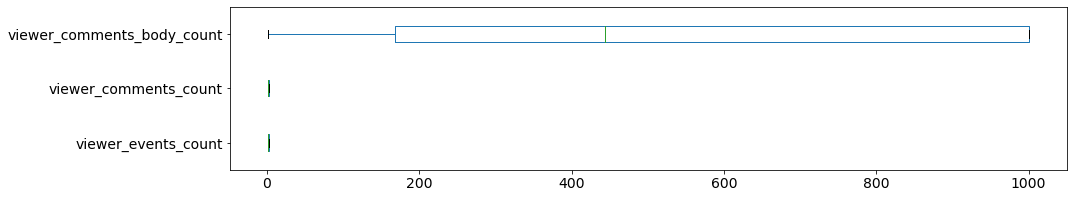

In [116]:
# Explore data distribution to get intuition on scoring
# Even after removing outliers in preprocessing,
# the two ranges have very different dimensionality without normalisation.
df[scoring_fields].where(df[scoring_fields] > 0).plot.box(vert=False,figsize=(15,3))

<AxesSubplot:>

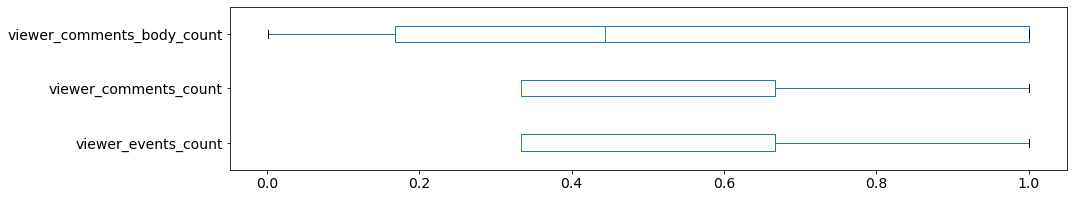

In [117]:
# Naive min-max normalisation to avoid one feature overly influencing the scoring
df[scoring_fields] = df[scoring_fields].apply(normalise)
df[scoring_fields].where(df[scoring_fields] > 0).plot.box(vert=False,figsize=(15,3))

In [118]:
# Calculate score with different weights
# TODO Use apply() and add()
scoring_weights = list(scoring.values())
df['score'] = normalise(
    df[scoring_fields[0]] * scoring_weights[0]
    + df[scoring_fields[1]] * scoring_weights[1]
    + df[scoring_fields[2]] * scoring_weights[2]
)
df[scoring_fields + ['score']].sort_values(by='score', ascending=False).head()

# Optionally use score as a categorical value, lower fidelity but also lower noise
if use_cat:
    df['score'] = df['score'].apply(lambda x: 1 if x > 0 else 0)

<AxesSubplot:>

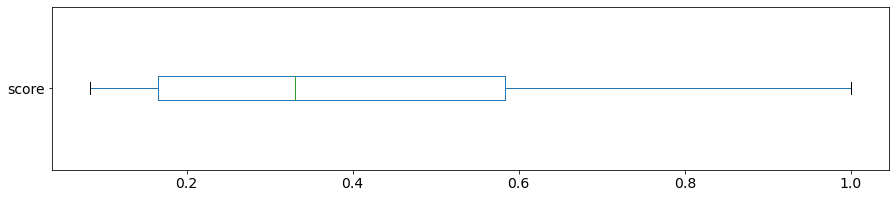

In [119]:
# Scoring distribution (excl. zeroes)
# It's skewed to lower scores, since low interactions are more common than high interactions
# This plot is only useful with use_cat=False
df['score'].where(df['score'] > 0).plot.box(vert=False,figsize=(15,3))

<AxesSubplot:ylabel='Frequency'>

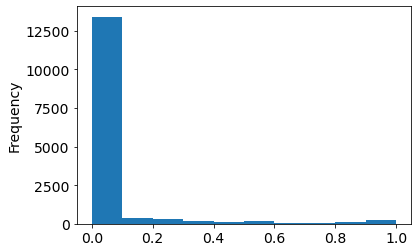

In [120]:
# Scoring histogram (incl. zeroes)
# There are way more items where the viewer has never interacted (score=0)
# This plot is only useful with use_cat=False
df['score'].plot.hist()

In [121]:
# Percentage of rows where score=0
len(df[df['score'] == 0]) / len(df)

0.8837162837162837

In [122]:
df[(df['score'] > 0)][:3]

,,Unnamed: 0,item_id,org_id,repo_id,creator_login,type,created_at,viewer_is_at_mentioned,title_chars_count,body_chars_count,markdown_chars_count,viewer_repo_issues_opened_count,viewer_repo_pull_requests_opened_count,creator_repo_issues_opened_count,creator_repo_pull_requests_opened_count,viewer_events_count,viewer_comments_count,all_at_mentions,all_actors,events_count,comments_count,comments_body_count,at_mentions_count,viewer_at_mentions_count,viewer_comments_body_count,score
item_url,fresh,,,,,,,,,,,,,,,,,,,,,,,,,,
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/6026,False,10,177694246,379348.0,1318892,sminnee,IssuesEvent,2016-09-19 02:25:03+00:00,False,71,987.0,3.0,5.0,5.0,5,5,0.666667,0.666667,",,,,,,,","sminnee,ScopeyNZ,robbieaverill,chillu,jakxnz,dhensby,ScopeyNZ,chillu",8,6,2453.0,0.0,0,0.145,0.536250
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/6030,False,23,177826649,379348.0,1318892,dhensby,IssuesEvent,2016-09-19 16:06:48+00:00,False,33,222.0,0.0,5.0,5.0,5,5,0.333333,0.333333,",,,,@chillu,,,,,,,,,,,,,,,@chillu,@tractorcow,,,,,,,","sminnee,tractorcow,tractorcow,dhensby,tractorcow,tractorcow,marcinqunabu,tractorcow,sminnee,chillu,sminnee,sminnee,tractorcow,sminnee,dhensby,sminnee,sminnee,sminnee,flamerohr,sminnee,robbieaverill,tractorcow,tractorcow,sminnee,sminnee,sminnee,tractorcow",27,25,8379.0,3.0,2,0.117,0.279250
https://api.github.com/repos/silverstripe/silverstripe-framework/pulls/6031,False,25,85879027,379348.0,1318892,tractorcow,PullRequestEvent,2016-09-19 22:10:54+00:00,False,30,0.0,0.0,5.0,5.0,5,5,0.333333,0.000000,",","tractorcow,chillu",2,0,165.0,0.0,0,0.164,0.124333


In [123]:
# Duplicate any items without "temporal" data.
# The model should be able to perform well on newly created issues
# without penalising them for not having any events (yet).
# It's important to do this *after* calculating the scores
if use_fresh:
    temporal_overrides = {
      'viewer_events_count': 0,
      'viewer_comments_count': 0,
      'viewer_comments_body_count': 0,
    }
    df_fresh = df.copy().assign(**temporal_overrides)
    # Avoid index clashes and make altered rows identifiable during validation
    df_fresh['fresh'] = True
    df = df.append(df_fresh)

In [124]:
# Don't include scoring_fields in here since that would be cheating
cat_names = [
  'org_id',
  'repo_id',
  'creator_login',
  'type',
  'viewer_is_at_mentioned',
]
cont_names = [
  'title_chars_count',
  'body_chars_count',
  'markdown_chars_count',
  'viewer_repo_issues_opened_count',
  'viewer_repo_pull_requests_opened_count',
  'creator_repo_issues_opened_count',
  'creator_repo_pull_requests_opened_count',
  'events_count',
  'comments_count',
  'comments_body_count',
  'viewer_at_mentions_count',
  'at_mentions_count',
]

In [125]:
# Create fast.ai (PyTorch) data set
tp = TabularPandas(
    df[cat_names + cont_names + ['score']],
    cat_names=cat_names,
    cont_names=cont_names,
    procs=[
      FillMissing,
      Categorify,
      Normalize
    ],
    y_names='score',
    # Optionally use score as a categorical value, lower fidelity but also lower noise
    y_block=CategoryBlock if use_cat else None,
    splits=RandomSplitter(valid_pct=0.2)(range_of(df))
)

In [126]:
learn = tabular_learner(tp.dataloaders(bs=64), metrics=accuracy)

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.0006918309954926372)

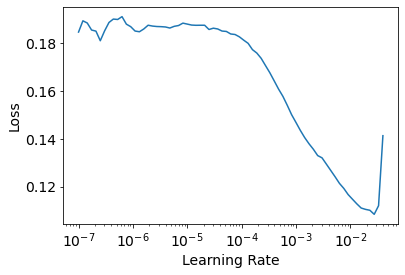

In [127]:
# Intuit the learning rate
learn.lr_find()

In [128]:
learn.fit_one_cycle(1, lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.019352,0.017965,0.881785,00:02


In [26]:
learn.show_results()

,org_id,repo_id,creator_login,type,viewer_is_at_mentioned,title_chars_count,body_chars_count,markdown_chars_count,viewer_repo_issues_opened_count,viewer_repo_pull_requests_opened_count,creator_repo_issues_opened_count,creator_repo_pull_requests_opened_count,events_count,comments_count,comments_body_count,viewer_at_mentions_count,at_mentions_count,score,score_pred
0,4.0,100.0,487.0,2.0,1.0,1.020639,-0.374517,-0.245031,0.758111,0.878591,0.872615,0.755815,-0.421998,-0.251955,-0.410965,-0.126183,-0.322746,0.0,0.0
1,4.0,60.0,337.0,2.0,1.0,-1.885197,-0.374517,-0.245031,-1.594302,-0.945088,-1.576415,-0.759304,-0.421998,-0.449907,-0.427575,-0.126183,-0.322746,0.0,0.0
2,4.0,20.0,318.0,1.0,1.0,-1.110307,3.778246,3.556430,0.758111,0.878591,0.872615,0.755815,2.692557,2.717324,4.118535,-0.126183,0.236560,1.0,0.0
3,9.0,67.0,685.0,2.0,1.0,-0.626001,-0.374517,-0.245031,0.758111,0.878591,0.872615,0.755815,-0.421998,-0.449907,-0.427575,-0.126183,-0.322746,0.0,0.0
4,4.0,76.0,813.0,2.0,1.0,0.294180,-0.374517,-0.245031,-1.594302,-0.489169,-1.576415,-1.264344,-0.421998,-0.449907,-0.427575,-0.126183,-0.322746,0.0,0.0
5,4.0,76.0,807.0,2.0,1.0,-0.868154,-0.319398,-0.245031,-1.594302,-0.489169,-1.576415,-0.759304,-0.227338,-0.251955,-0.385497,-0.126183,-0.322746,0.0,0.0
6,1.0,108.0,318.0,2.0,1.0,-0.722862,-0.311848,-0.113946,-0.182854,-0.945088,-1.086609,-0.759304,2.497897,2.519372,0.307410,-0.126183,-0.322746,0.0,0.0
7,4.0,58.0,520.0,2.0,1.0,-0.190126,0.210645,0.148223,-1.123819,-1.401008,-1.576415,-1.264344,0.161981,0.143949,0.104493,-0.126183,0.236560,0.0,0.0
8,9.0,67.0,685.0,1.0,1.0,0.681625,0.826764,1.852327,0.758111,0.878591,0.872615,0.755815,-0.421998,-0.251955,0.042483,-0.126183,1.914477,0.0,0.0


In [27]:
interp = Interpretation.from_learner(learn)
top_losses = interp.top_losses()
to_top_losses = learn.dls.valid.dataset.iloc[top_losses.indices]
df_top_losses = to_top_losses.decode().items
df_top_losses['loss'] = top_losses.values
df_top_losses[cat_names + cont_names + ['score', 'loss']]

org_id  \
item_url                                                                     fresh           
https://api.github.com/repos/silverstripe/silverstripe-framework/pulls/6829  False  379348   
                                                                             False  379348   
https://api.github.com/repos/silverstripe/cwp-core/pulls/25                  False  379348   
https://api.github.com/repos/silverstripe/silverstripe-tagfield/issues/145   False  379348   
https://api.github.com/repos/silverstripe/silverstripe-userforms/pulls/933   False  379348   
...                                                                                    ...   
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/8556 False  379348   
                                                                             False  379348   
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/6457 False  379348   
https://api.github.com/repos/silverstripe/silverstripe-versioned/issues/177  False  379348   
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/7032 False  379348   

                                                                                      repo_id  \
item_url                                                                     fresh              
https://api.github.com/repos/silverstripe/silverstripe-framework/pulls/6829  False    1318892   
                                                                             False    1318892   
https://api.github.com/repos/silverstripe/cwp-core/pulls/25                  False  113399915   
https://api.github.com/repos/silverstripe/silverstripe-tagfield/issues/145   False    1181344   
https://api.github.com/repos/silverstripe/silverstripe-userforms/pulls/933   False    1247754   
...                                                                                       ...   
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/8556 False    1318892   
                                                                             False    1318892   
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/6457 False    1318892   
https://api.github.com/repos/silverstripe/silverstripe-versioned/issues/177  False   85634633   
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/7032 False    1318892   

                                                                                   creator_login  \
item_url                                                                     fresh                 
https://api.github.com/repos/silverstripe/silverstripe-framework/pulls/6829  False       sminnee   
                                                                             False       sminnee   
https://api.github.com/repos/silverstripe/cwp-core/pulls/25                  False       madmatt   
https://api.github.com/repos/silverstripe/silverstripe-tagfield/issues/145   False         cloph   
https://api.github.com/repos/silverstripe/silverstripe-userforms/pulls/933   False    brynwhyman   
...                                                                                          ...   
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/8556 False        chillu   
                                                                             False        chillu   
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/6457 False        chillu   
https://api.github.com/repos/silverstripe/silverstripe-versioned/issues/177  False        nglasl   
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/7032 False        chillu   

                                                                                                type  \
item_url                                                                     fresh                     
https://api.github.com/repos/silverstripe/silverstripe-framework/pulls/6829  False  PullRe

In [28]:
# dl_train = learn.dls[1]
# _,_,preds = learn.get_preds(dl=dl_train, with_decoded=True)
# df_train = dl_train.all_cols
# df_train['score_pred'] = preds
# learn.dls.show_results(b, preds)

In [146]:
# Validate with a new (previously unseen) test data set
test_data = fetch(
    url='https://github.com/silverstripe/silverstripe-framework/issues/9688',
    viewer_login=var_viewer_login,
    github_api_token=os.getenv('GITHUB_API_TOKEN')
)
# Create DataFrame
test_df = pd.DataFrame.from_dict([test_data])
# Reapply preprocessing
test_df = preprocess(test_df)
# Select fields we've actually used
# This also ensures data is presented in the same order, which is important for the Random Forest classifier
test_df = test_df[cat_names + cont_names]

In [147]:
# Run neural net prediction
row, pred, probs = learn.predict(test_df.iloc[0])
row.show()
pred

,org_id,repo_id,creator_login,type,viewer_is_at_mentioned,title_chars_count,body_chars_count,markdown_chars_count,viewer_repo_issues_opened_count,viewer_repo_pull_requests_opened_count,creator_repo_issues_opened_count,creator_repo_pull_requests_opened_count,events_count,comments_count,comments_body_count,viewer_at_mentions_count,at_mentions_count,score
0,379348,1318892,sminnee,PullRequestEvent,False,117.999999,2645.99993,15.0,5.0,5.0,5.0,5.0,8.0,8.0,4988.999952,1.236510e-09,1.0,0.200884


tensor([0.2009])

In [148]:
learn.export('/storage/model.pkl')

In [149]:
# Alternative approach: Random Forest
from sklearn import ensemble
xs,y = tp.train.xs,tp.train.y
valid_xs,valid_y = tp.valid.xs,tp.valid.y
cls = ensemble.RandomForestClassifier if use_cat else ensemble.RandomForestRegressor
tree_model = cls(
    n_jobs=-1,
    n_estimators=100,
    min_samples_leaf=20,
    oob_score=True
)
tree_model.fit(xs, y)
tree_model.score(valid_xs, valid_y)

0.5173345188733971

In [150]:
# Run Random Forest prediction
# Apply processing to data by creating it as a one-element test dataloader.
# Unlike tabular_learner(), scikit doesn't handle this automatically.
# CAUTION: Assumes parameters are in the same order
test_dl = learn.dls.test_dl(test_df)
test_dl.dataset.conts = test_dl.dataset.conts.astype(np.float32)
test_dl.dataset.loc[0]
tree_model.predict([test_dl.dataset.loc[0]])

array([0.18737284])

<AxesSubplot:ylabel='cols'>

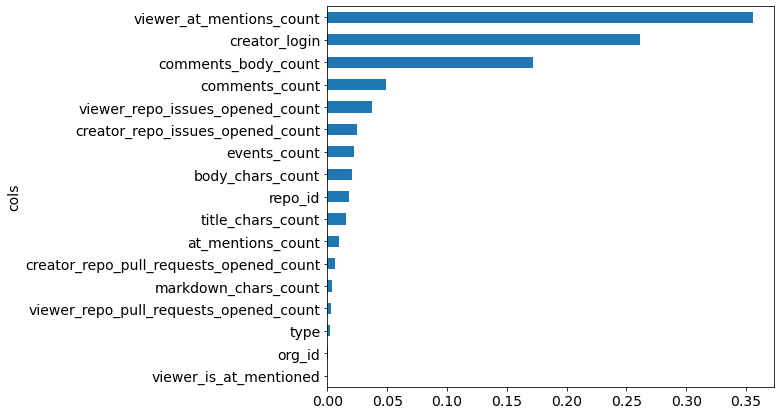

In [151]:
fi = pd.DataFrame({
    'cols':xs.columns, 
    'imp':tree_model.feature_importances_
}).sort_values('imp', ascending=True)
fi.plot('cols', 'imp', 'barh', figsize=(8,7), legend=False)